In [1]:
#We import all the necessary libraries required to process the data and build the model.
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from IPython.display import HTML

In [3]:

BATCH_SIZE = 32
IMAGE_SIZE = 256
CHANNELS=3
EPOCHS=50

In [4]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "K:\\HAM\\data\\train",
    seed=123,
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2637 files belonging to 2 classes.


In [5]:
class_names = dataset.class_names
class_names

['benign', 'malignant']

In [6]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 0 1 0 0 0 0 1 0 0 0 0 0 1 0 0 0 0 1 0 0 1 1 1 0 0 0 0 1 0 1]


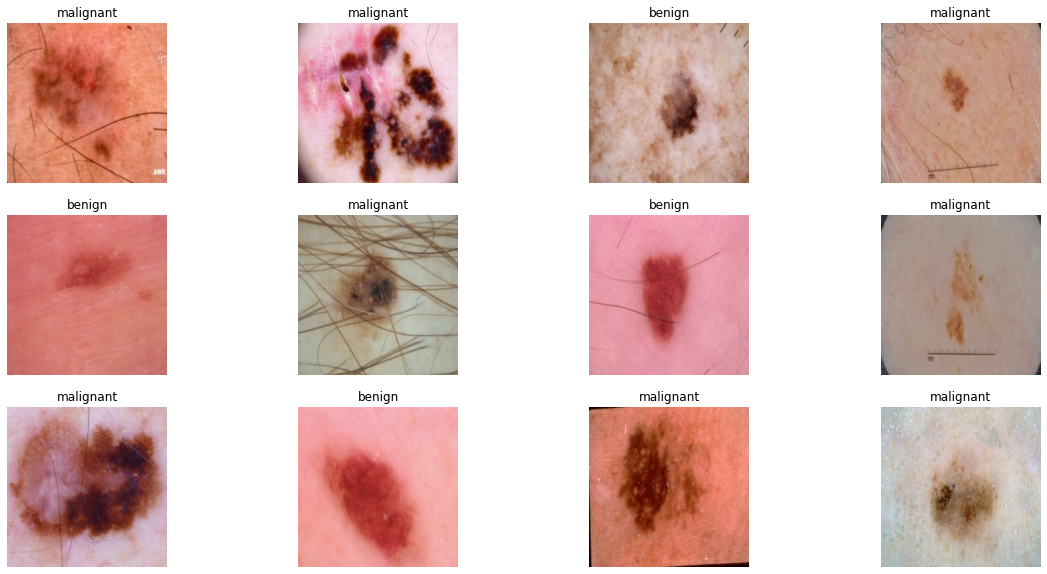

In [7]:
plt.figure(figsize=(20, 10))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

In [8]:
def Img_preprocessing(n): 
 
    gray_scale=cv2.cvtColor(n, cv2.COLOR_BGR2GRAY ) 
 
    img_size=800
    resized_img=cv2.resize(gray_scale,(img_size,img_size)) 

    equ = cv2.equalizeHist(resized_img)
  
    blur=cv2.medianBlur(equ,5)
   
    grad_x = cv2.Sobel(blur, cv2.CV_16S, 1, 0, ksize=3, scale=1, delta=0, borderType=cv2.BORDER_DEFAULT)
    grad_y = cv2.Sobel(blur, cv2.CV_16S, 0, 1, ksize=3, scale=1, delta=0, borderType=cv2.BORDER_DEFAULT)
    abs_grad_x = cv2.convertScaleAbs(grad_x)
    abs_grad_y = cv2.convertScaleAbs(grad_y)
    edges = cv2.addWeighted(abs_grad_x, 0.5, abs_grad_y, 0.5, 0)   #sobel derivative
    clean_data =edges
    return clean_data

In [10]:
import os
import cv2
dir1="K:\\HAM\\data\\train"
catg=['benign', 'malignant']
img_cube=[]
image_size=800

for i in catg: #this will take the folder names as we call it as categoris
    path=os.path.join(dir1,i)
    label=catg.index(i)
    for j in os.listdir(path): #this will take the actual path of each folder image
        img_arr=cv2.imread(os.path.join(path,j)) #convert rgb image to gray scale image
        final_data=Img_preprocessing(img_arr)
        img_cube.append((final_data,label))
print("Length of your dataset: ",len(img_cube))
print("Whole image data in array format:\n",img_cube)

Length of your dataset:  2637
Whole image data in array format:
 [(array([[ 0,  0,  0, ..., 14,  7,  0],
       [ 0,  0,  0, ..., 21, 21, 14],
       [ 4,  4,  2, ..., 21, 28, 28],
       ...,
       [ 0,  0,  0, ...,  8,  9,  6],
       [ 0,  0,  0, ...,  6,  5,  3],
       [ 0,  0,  0, ...,  4,  2,  0]], dtype=uint8), 0), (array([[ 0,  0,  0, ..., 26,  0,  0],
       [ 0,  0,  0, ..., 39, 13,  0],
       [ 0,  0,  0, ..., 39, 39, 13],
       ...,
       [ 2,  3,  2, ...,  6,  6,  2],
       [ 1,  1,  0, ...,  6,  5,  3],
       [ 0,  0,  0, ...,  4,  3,  0]], dtype=uint8), 0), (array([[ 0,  0,  0, ..., 16,  0,  0],
       [ 0,  0,  0, ..., 16,  0,  0],
       [ 5,  5,  0, ..., 24,  8,  0],
       ...,
       [ 3,  9, 12, ..., 19, 26, 26],
       [ 0,  3,  9, ..., 21, 21, 14],
       [ 0,  0,  6, ..., 14,  7,  0]], dtype=uint8), 0), (array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [4, 4, 4, ..., 0, 0, 0],
       ...,
       [4, 4, 4, ..., 2, 0, 0],
       [2, 2,

In [13]:
len(dataset)


83

In [14]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [15]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)


In [16]:
len(train_ds)

66

In [17]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [18]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [19]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [20]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [21]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 14

model = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model.build(input_shape=input_shape)

In [22]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential (Sequential)      (32, 256, 256, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (32, 254, 254, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (32, 127, 127, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (32, 125, 125, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (32, 62, 62, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (32, 60, 60, 64)          36928     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (32, 30, 30, 64)         

In [23]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)


In [24]:
history = model.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
66/66 [==============================] - 77s 1s/step - loss: 0.8444 - accuracy: 0.5017 - val_loss: 0.6880 - val_accuracy: 0.6367
Epoch 2/50
66/66 [==============================] - 67s 1s/step - loss: 0.6680 - accuracy: 0.5905 - val_loss: 0.5809 - val_accuracy: 0.6211
Epoch 3/50
66/66 [==============================] - 69s 1s/step - loss: 0.5655 - accuracy: 0.7114 - val_loss: 0.4566 - val_accuracy: 0.7578
Epoch 4/50
66/66 [==============================] - 73s 1s/step - loss: 0.4886 - accuracy: 0.7625 - val_loss: 0.4340 - val_accuracy: 0.7891
Epoch 5/50
66/66 [==============================] - 71s 1s/step - loss: 0.4788 - accuracy: 0.7621 - val_loss: 0.4302 - val_accuracy: 0.7852
Epoch 6/50
66/66 [==============================] - 71s 1s/step - loss: 0.4618 - accuracy: 0.7836 - val_loss: 0.4439 - val_accuracy: 0.7344
Epoch 7/50
66/66 [==============================] - 71s 1s/step - loss: 0.4589 - accuracy: 0.7793 - val_loss: 0.4189 - val_accuracy: 0.7930
Epoch 8/50
66/66 [==

In [25]:
scores = model.evaluate(test_ds)

9/9 [==============================] - 2s 254ms/step - loss: 0.3321 - accuracy: 0.8646


In [26]:
scores

[0.33206605911254883, 0.8645833134651184]

In [27]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 66}

In [28]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [29]:
type(history.history['loss'])

list

In [30]:
len(history.history['loss'])


50

In [31]:
history.history['loss'][:5] # show loss for first 5 epochs

[0.844413697719574,
 0.6679970026016235,
 0.5654600858688354,
 0.4886353313922882,
 0.4788433611392975]

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']


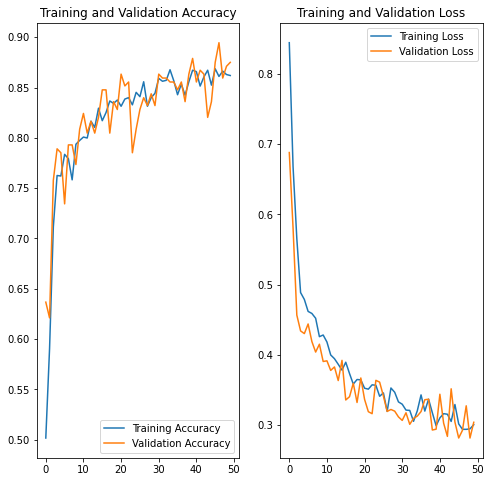

In [33]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: malignant
predicted label: malignant


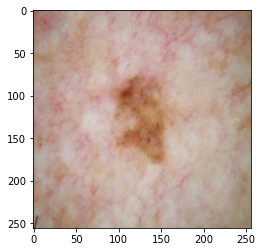

In [34]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [35]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    accuracy = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, accuracy

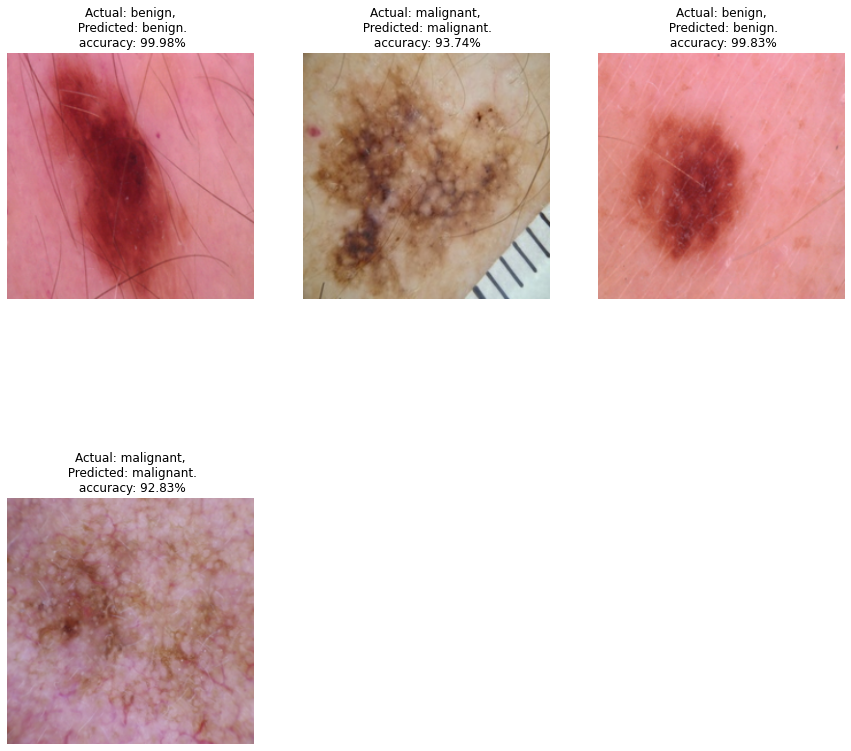

In [42]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(4):
        ax = plt.subplot(2, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, accuracy = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n accuracy: {accuracy}%")
        
        plt.axis("off")